# Time Course of Dendra2 Activation
## The Data
Experiment Date: 09/24/18

## Analysis
Use FlowCytometryTools.

In [1]:
## load packages
import pandas as pd
import FlowCytometryTools as fct
import numpy as np
import pandas as pd
import os
import sklearn.metrics as skmet
import itertools

from pylab import *
from plotnine import *
from plotnine.data import *
from itertools import combinations

# make ggplot classic looking
ggplot_classic = theme(panel_background = element_rect(fill='white'), panel_border=element_rect(color='black', size=1), panel_grid_major = element_blank(), panel_grid_minor = element_blank(), legend_box = element_rect(fill="white", size = 0.5)) 

C:\Users\nickh\Anaconda3\lib\site-packages\FlowCytometryTools\core\docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
C:\Users\nickh\Anaconda3\lib\site-packages\FlowCytometryTools\core\docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


## Functions

In [2]:
# parser to get well identities from file names
def parser(filename):
    return(filename.strip().split('_')[-2])

# log transform to log transform FITC (unactivated Dendra2) and PE (activated Dendra2) channels
def log_transform(original_sample, other_channels = []):
    """ This function implements a log transformation on the data. """
    # Copy the original sample
    new_sample = original_sample.copy()
    new_data = new_sample.data

    # Our transformation goes here
    new_data['FITC-A'] = log(new_data['FITC-A'])
    new_data['PE-A'] = log(new_data['PE-A'])
    
    # parse through other fluorescent channels, if added
    if len(other_channels) > 1:
        for channel in other_channels:
            new_data[channel] = log(new_data[channel])
    
    new_data = new_data.dropna()  # Removes all NaN entries
    new_sample.data = new_data
    return new_sample

## Load Metadata

In [3]:
metadat = pd.read_csv('../data/metadat.csv')

metadat

,well_id,column,row,activation_ms,replicate,doxycycline,timepoint
0,A02,2,A,0,NaN,-,0
1,A03,3,A,0,NaN,+,0
2,A04,4,A,0,R1,-,0
3,A05,5,A,0,R1,+,0
4,A06,6,A,0,R2,-,0
...,...,...,...,...,...,...,...
65,G07,7,G,200,R2,+,2
66,G08,8,G,800,R1,-,2
67,G09,9,G,800,R1,+,2
68,G10,10,G,800,R2,-,2


In [4]:
## final dataframe
# match final dataframe with file path
fcsfiles = [file for file in os.listdir('../data/') if file[-3:] == 'fcs']
metadat['fcs_file_path'] = metadat.well_id.apply(lambda x: ['../data/%s' % (file) for file in fcsfiles if file.split('_')[-2] == x])
# remove missing files
metadat['fcs_file_path'] = metadat.fcs_file_path.apply(lambda x: x[0] if len(x) > 0 else None)


metadat

,well_id,column,row,activation_ms,replicate,doxycycline,timepoint,fcs_file_path
0,A02,2,A,0,NaN,-,0,None
1,A03,3,A,0,NaN,+,0,None
2,A04,4,A,0,R1,-,0,../data/Specimen_002_A4_A04_061.fcs
3,A05,5,A,0,R1,+,0,../data/Specimen_002_A5_A05_062.fcs
4,A06,6,A,0,R2,-,0,../data/Specimen_003_A6_A06_063.fcs
...,...,...,...,...,...,...,...,...
65,G07,7,G,200,R2,+,2,../data/Specimen_001_G7_G07_056.fcs
66,G08,8,G,800,R1,-,2,../data/Specimen_001_G8_G08_057.fcs
67,G09,9,G,800,R1,+,2,../data/Specimen_001_G9_G09_058.fcs
68,G10,10,G,800,R2,-,2,../data/Specimen_001_G10_G10_059.fcs


In [5]:
# load all data
plate = fct.FCPlate.from_dir(ID = 'plate', path = '../data/', parser = parser, position_mapper = 'name')

# remove empty placeholders
plate = plate.dropna()

# apply a log transform to the data, and calculate the ratio
for well in plate.data.keys():
    plate.data[well] = log_transform(plate.data[well])
    plate.data[well].data['ratio'] = pd.to_numeric(plate.data[well].data.loc[:,'PE-A']).div(pd.to_numeric(plate.data[well].data.loc[:,'FITC-A']), axis = 0)
    
print(plate)

C:\Users\nickh\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nickh\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ID:
plate

Data:
    2    3    4    5    6    7    8    9    10   11
A            A04  A05  A06  A07                    
B  B02  B03  B04  B05  B06  B07  B08  B09  B10  B11
C  C02  C03  C04  C05  C06  C07  C08  C09  C10  C11
D  D02  D03  D04  D05  D06  D07  D08  D09  D10  D11
E  E02  E03  E04  E05  E06  E07  E08  E09  E10  E11
F  F02  F03  F04  F05  F06  F07  F08  F09  F10  F11
G  G02  G03  G04  G05  G06  G07  G08  G09  G10  G11


## Set control gates
### A05 as control + live gate (gate1)

C:\Users\nickh\Anaconda3\lib\site-packages\matplotlib\colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


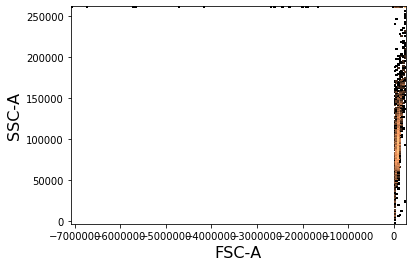

In [6]:
# pick A05 as control
cntrl = plate['A04']

# plot live cells
p1 = cntrl.plot(['FSC-A', 'SSC-A'])

# define gate for live cells
gate1 = fct.PolyGate([(7e+04, 7e+04), (5e+05, 1.2e+06), (8e+04, 2e+05), (2.2e+05, 2e+05), (2.3e+05, 1e+05)], ('FSC-A', 'SSC-A'), region='in', name='gate1')


C:\Users\nickh\Anaconda3\lib\site-packages\matplotlib\colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


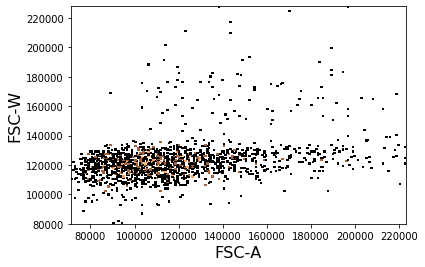

In [7]:
## apply live gate
live = cntrl.gate(gate1)

# plot singlets
p2 = live.plot(['FSC-A', 'FSC-W'])

# define gate for singlets
gate2 = fct.ThresholdGate(140000, ['FSC-W'], region = 'below')

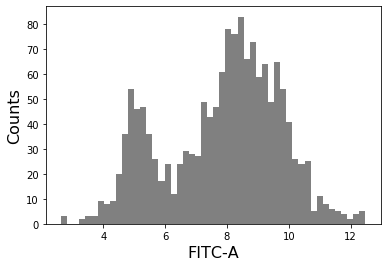

In [8]:
## apply singlets gate
singlets = live.gate(gate2)

# remove negative infinity values
singlets.data = singlets.data.replace(-np.Inf, NaN).dropna()

## plot FITC
p3 = singlets.plot(['FITC-A'], bins = 50)

## define FITC gate
#gate3 = fct.ThresholdGate(8, ['FITC-A'], region = 'above')

C:\Users\nickh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


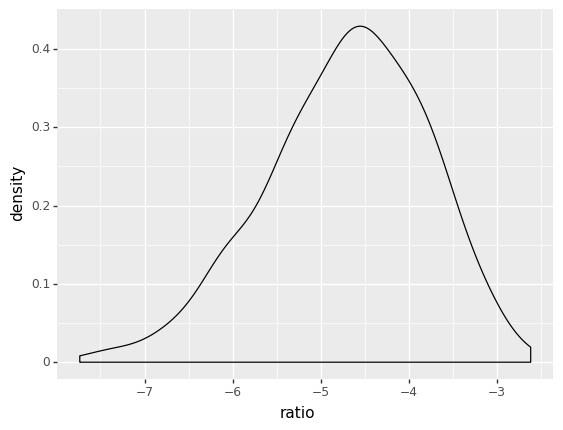

<ggplot: (161388023886)>

In [9]:
## plot ratio
gate3 = fct.ThresholdGate(8, ['FITC-A'], region = 'above')

df = singlets.gate(gate3).data
df['ratio'] = df['PE-A'] - df['FITC-A']

ggplot(aes(x = 'ratio'), df) + geom_density()

## Apply gates to plate and analyze activation

In [10]:
# use all three gates
plate_gated = plate.gate(gate1).gate(gate2).gate(gate3)

# concatenate all data into one big dataframe
all_dataframes = []
for well in plate_gated.keys():
    well_df = plate_gated[well].data
    well_df['well'] = well
    all_dataframes.append(well_df)

all_dataframes = pd.concat(all_dataframes)

# make the ratio
## taking the ratio of unlogged data, then logging it = subtracting the logged data
all_dataframes['ratio'] = all_dataframes['PE-A'] - all_dataframes['FITC-A']

# annotate
all_dataframes_annotated = all_dataframes.merge(metadat, left_on = 'well', right_on = 'well_id')

all_dataframes_annotated.iloc[:10,:]

C:\Users\nickh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,FSC-A,FSC-W,SSC-A,PE-A,FITC-A,Time,ratio,well,well_id,column,row,activation_ms,replicate,doxycycline,timepoint,fcs_file_path
0,103432.203125,130766.312500,119582.132812,6.145965,9.776165,941.400024,-3.630200,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
1,79347.039062,111692.929688,87125.828125,4.818344,8.896592,983.299988,-4.078248,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
2,102309.898438,114933.351562,79232.437500,4.968284,8.742539,984.500000,-3.774255,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
3,144441.296875,123597.750000,150187.343750,5.755014,10.201425,1020.200012,-4.446411,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
4,151498.468750,124988.710938,137129.062500,6.349821,10.717052,1020.900024,-4.367231,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
5,130946.179688,122746.359375,116802.273438,5.228699,9.579658,1021.200012,-4.350958,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
6,79118.281250,120721.187500,77280.750000,5.515161,8.931274,1022.000000,-3.416113,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
7,174337.484375,127455.679688,121333.726562,7.084997,11.128672,1022.200012,-4.043674,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
8,127748.703125,119949.835938,109314.414062,4.810964,8.071691,1023.400024,-3.260726,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs
9,146164.750000,125332.703125,127979.500000,4.701480,8.481489,1023.900024,-3.780009,B10,B10,10,B,50,R1,-,48,../data/Specimen_001_B10_B10_009.fcs


C:\Users\nickh\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\nickh\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 45 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


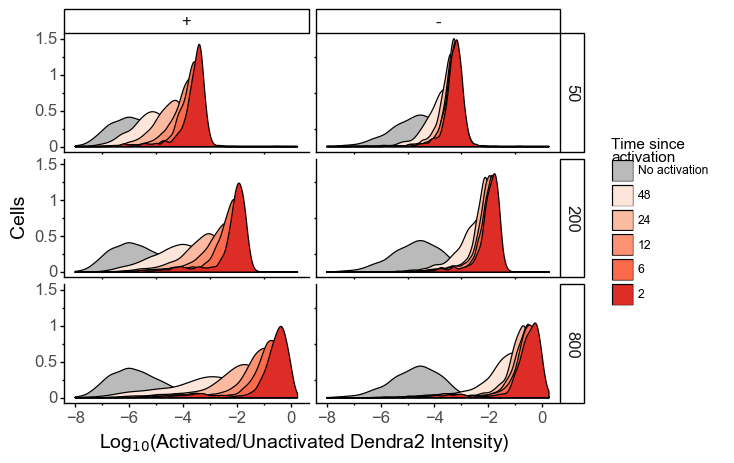

<ggplot: (161390385174)>

In [11]:
## make timepoint a factorized variable
timepoint_cat = pd.api.types.CategoricalDtype(categories=all_dataframes_annotated.timepoint.sort_values().unique(),
                                 ordered=True)
all_dataframes_annotated.timepoint = all_dataframes_annotated.timepoint.astype(timepoint_cat)

## copy the timepoint 0 across the other activations, so it can be displayed across facets
def make_new_df(activation): # function that puts the negative control in each activation bin
    subdf = all_dataframes_annotated.loc[all_dataframes_annotated.activation_ms == 0,]
    subdf.activation_ms = activation
    return(subdf)
extra_dfs = pd.Series([50,200,800]).apply(lambda x: make_new_df(x)) # apply to all other activations
to_plot = pd.concat([all_dataframes_annotated.loc[all_dataframes_annotated.activation_ms != 0,]] + list(extra_dfs), axis = 0)

## Make more accurate labels for the colors
new_labs = pd.DataFrame({'timepoint':[0,2,6,12,24,48],
                        'time_since_activation':['No activation', '2','6','12','24','48']})
timesinceact_cat = pd.api.types.CategoricalDtype(['2','6','12','24','48', 'No activation'][::-1],
                                 ordered=True)
new_labs.timepoint = new_labs.timepoint.astype(timepoint_cat)
new_labs.time_since_activation = new_labs.time_since_activation.astype(timesinceact_cat)
to_plot = to_plot.merge(new_labs, on='timepoint')

## plot the data with histogram
sf1a_base = ggplot(aes(x = 'ratio',
                       fill = 'time_since_activation'),
                   data = to_plot)
sf1a_dens = geom_density(color='black')
sf1a_lims = xlim(-8, 0.25)
sf1a_xlab = xlab('Log$_{10}$(Activated/Unactivated Dendra2 Intensity)')
sf1a_ylab = ylab('Cells')
sf1a_them = theme_classic() + theme(text=element_text(family="Arial"),
                                    axis_text=element_text(size=12),
                                    axis_title=element_text(size=14),
                                    strip_text=element_text(size=12))
sf1a_face = facet_grid('activation_ms~doxycycline')
sf1a_cols = scale_fill_manual(values=['#bababa','#fee5d9','#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15'])
sf1a_guid = guides(fill=guide_legend(title='Time since\nactivation'))

f1 = sf1a_base + sf1a_dens + sf1a_lims + sf1a_xlab + sf1a_ylab + sf1a_them + sf1a_face + sf1a_cols + sf1a_guid
f1

In [12]:
sf1a = sf1a_base + sf1a_dens + sf1a_lims + sf1a_xlab + sf1a_ylab + sf1a_them + sf1a_face + sf1a_cols + sf1a_guid + theme(text = element_text(size=10), axis_title = element_text(size=12), legend_title=element_blank())
ggsave(sf1a, 'EV1B.png', dpi = 600, width = 4.5, height = 4)

C:\Users\nickh\AppData\Roaming\Python\Python37\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 4.5 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\nickh\AppData\Roaming\Python\Python37\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: SF1A.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\nickh\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_density : Removed 45 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
